# P9 - Produisez une étude de marché

## Préparation des fichiers

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import decomposition, preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

* Fonction qui affiche le cercle des corrélations

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:],
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables
            if labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

* Fonction qui affiche la projection des individus

In [3]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

* Création d'une classe pour améliorer le style du texte.

In [4]:
class color:
    BOLD = '\033[1m'
    END = '\033[0m'
    UNDERLINE = '\033[4m'

* Lecture des fichiers

In [5]:
alimentaires = pd.read_csv('DisponibiliteAlimentaire_2017.csv')
populations = pd.read_csv('Population_2000_2018.csv')

In [6]:
alimentaires

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.00,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.00,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.00,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.00,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.00,S,Données standardisées
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176595,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5142,Nourriture,2899,Miscellanees,2017,2017,Milliers de tonnes,19.00,S,Données standardisées
176596,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,645,Disponibilité alimentaire en quantité (kg/pers...,2899,Miscellanees,2017,2017,kg,1.33,Fc,Donnée calculée
176597,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,664,Disponibilité alimentaire (Kcal/personne/jour),2899,Miscellanees,2017,2017,Kcal/personne/jour,1.00,Fc,Donnée calculée
176598,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,674,Disponibilité de protéines en quantité (g/pers...,2899,Miscellanees,2017,2017,g/personne/jour,0.04,Fc,Donnée calculée


In [7]:
populations

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2014,2014,1000 personnes,13586.707,X,Sources internationales sûres,NaN
4407,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,13814.629,X,Sources internationales sûres,NaN
4408,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2016,2016,1000 personnes,14030.331,X,Sources internationales sûres,NaN
4409,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,14236.595,X,Sources internationales sûres,NaN


* Vérification des valeurs manquantes

In [8]:
alimentaires.isnull().sum()

Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64

In [9]:
populations.isnull().sum()

Code Domaine                 0
Domaine                      0
Code zone                    0
Zone                         0
Code Élément                 0
Élément                      0
Code Produit                 0
Produit                      0
Code année                   0
Année                        0
Unité                        0
Valeur                       0
Symbole                      0
Description du Symbole       0
Note                      4153
dtype: int64

* Vérification des types

In [10]:
alimentaires.dtypes

Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
dtype: object

In [11]:
populations.dtypes

Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
Note                       object
dtype: object

* Vérification des doublons

In [12]:
alimentaires.loc[alimentaires[['Code Domaine','Domaine','Code zone','Zone','Code Élément','Élément','Code Produit','Produit','Code année','Année','Unité','Valeur','Symbole','Description du Symbole']].duplicated(keep=False),:]

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole


In [13]:
populations.loc[populations[['Code Domaine','Domaine','Code zone','Zone','Code Élément','Élément','Code Produit','Produit','Code année','Année','Unité','Valeur','Symbole','Description du Symbole','Note']].duplicated(keep=False),:]

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note


* Vue d'ensemble des valeurs pour les variables ['Valeurs'] dans les Dataframes

In [14]:
populations['Valeur'].describe()

count    4.411000e+03
mean     2.963004e+04
std      1.238029e+05
min      7.850000e-01
25%      3.921890e+02
50%      4.764741e+03
75%      1.821548e+04
max      1.427648e+06
Name: Valeur, dtype: float64

In [15]:
alimentaires['Valeur'].describe()

count    176600.000000
mean        210.554918
std        4762.047787
min      -10388.000000
25%           0.000000
50%           0.120000
75%           8.462500
max      758548.000000
Name: Valeur, dtype: float64

In [16]:
alimentaires.loc[alimentaires['Valeur'] < 0,:]

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
43,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2514,Maïs et produits,2017,2017,Milliers de tonnes,-21.0,S,Données standardisées
70,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2517,Millet et produits,2017,2017,Milliers de tonnes,-1.0,S,Données standardisées
110,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2535,Ignames,2017,2017,Milliers de tonnes,-1.0,S,Données standardisées
169,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2546,Haricots,2017,2017,Milliers de tonnes,-33.0,S,Données standardisées
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176003,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5072,Variation de stock,2577,Huile de Palme,2017,2017,Milliers de tonnes,-1.0,S,Données standardisées
176275,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5072,Variation de stock,2641,Piments,2017,2017,Milliers de tonnes,-1.0,S,Données standardisées
176356,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5072,Variation de stock,2731,Viande de Bovins,2017,2017,Milliers de tonnes,-1.0,S,Données standardisées
176379,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5072,Variation de stock,2733,Viande de Suides,2017,2017,Milliers de tonnes,-1.0,S,Données standardisées


* Filtrer des données sur l'année 2017 et stocker dans un Dataframe

In [17]:
population2017 = populations.loc[populations['Année'] == 2017]
population2017

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
17,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,36296.113,X,Sources internationales sûres,NaN
36,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,57009.756,X,Sources internationales sûres,NaN
55,OA,Séries temporelles annuelles,3,Albanie,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,2884.169,X,Sources internationales sûres,NaN
74,OA,Séries temporelles annuelles,4,Algérie,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,41389.189,X,Sources internationales sûres,NaN
93,OA,Séries temporelles annuelles,79,Allemagne,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,82658.409,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,OA,Séries temporelles annuelles,236,Venezuela (République bolivarienne du),511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,29402.484,X,Sources internationales sûres,NaN
4352,OA,Séries temporelles annuelles,237,Viet Nam,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,94600.648,X,Sources internationales sûres,NaN
4371,OA,Séries temporelles annuelles,249,Yémen,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,27834.819,X,Sources internationales sûres,NaN
4390,OA,Séries temporelles annuelles,251,Zambie,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,16853.599,X,Sources internationales sûres,NaN


In [18]:
aliment_poulet = alimentaires.loc[alimentaires['Produit'] == 'Viande de Volailles']
aliment_poulet

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
651,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28.00,S,Données standardisées
652,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29.00,S,Données standardisées
653,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2734,Viande de Volailles,2017,2017,Milliers de tonnes,0.00,S,Données standardisées
654,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2734,Viande de Volailles,2017,2017,Milliers de tonnes,57.00,S,Données standardisées
655,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5123,Pertes,2734,Viande de Volailles,2017,2017,Milliers de tonnes,2.00,S,Données standardisées
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176396,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5142,Nourriture,2734,Viande de Volailles,2017,2017,Milliers de tonnes,67.00,S,Données standardisées
176397,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2017,2017,kg,4.68,Fc,Donnée calculée
176398,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,664,Disponibilité alimentaire (Kcal/personne/jour),2734,Viande de Volailles,2017,2017,Kcal/personne/jour,16.00,Fc,Donnée calculée
176399,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,674,Disponibilité de protéines en quantité (g/pers...,2734,Viande de Volailles,2017,2017,g/personne/jour,1.59,Fc,Donnée calculée


* Vue d'ensemble des données dans le nouveau Dataframe

In [19]:
aliment_poulet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 651 to 176400
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            2061 non-null   object 
 1   Domaine                 2061 non-null   object 
 2   Code zone               2061 non-null   int64  
 3   Zone                    2061 non-null   object 
 4   Code Élément            2061 non-null   int64  
 5   Élément                 2061 non-null   object 
 6   Code Produit            2061 non-null   int64  
 7   Produit                 2061 non-null   object 
 8   Code année              2061 non-null   int64  
 9   Année                   2061 non-null   int64  
 10  Unité                   2061 non-null   object 
 11  Valeur                  2061 non-null   float64
 12  Symbole                 2061 non-null   object 
 13  Description du Symbole  2061 non-null   object 
dtypes: float64(1), int64(5), object(8)
m

In [20]:
pivot = pd.pivot_table(aliment_poulet, values='Valeur', index='Zone',
                    columns='Élément', aggfunc=np.sum)
pivot

Élément,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
Zone,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,5.0,1.53,0.33,0.54,57.0,NaN,29.0,55.0,2.0,28.0,0.0,NaN,NaN,0.0
Afrique du Sud,0.0,NaN,NaN,143.0,35.69,9.25,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,NaN,NaN,0.0
Albanie,NaN,NaN,NaN,85.0,16.36,6.45,6.26,47.0,0.0,38.0,47.0,NaN,13.0,0.0,NaN,NaN,4.0
Algérie,0.0,NaN,NaN,22.0,6.38,1.50,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,NaN,NaN,0.0
Allemagne,NaN,NaN,NaN,71.0,19.47,4.16,7.96,1739.0,646.0,842.0,1609.0,NaN,1514.0,-38.0,NaN,167.0,-29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,NaN,NaN,NaN,147.0,43.47,9.25,14.80,412.0,94.0,433.0,412.0,NaN,48.0,0.0,NaN,NaN,-26.0
Équateur,0.0,NaN,NaN,83.0,19.31,6.35,6.15,341.0,0.0,0.0,324.0,17.0,340.0,0.0,NaN,NaN,-1.0
États-Unis d'Amérique,NaN,NaN,89.0,219.0,55.68,14.83,19.93,18266.0,3692.0,123.0,18100.0,NaN,21914.0,0.0,NaN,77.0,80.0


## Analyse

* ACP : l' Analyse en Composantes Principales

In [21]:
# selection des colonnes à prendre en compte dans l'ACP
data_pca = pivot[['Alimentation pour touristes', 'Aliments pour animaux','Autres utilisations (non alimentaire)','Disponibilité alimentaire (Kcal/personne/jour)',
                 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Disponibilité de matière grasse en quantité (g/personne/jour)',
                 'Disponibilité de protéines en quantité (g/personne/jour)','Disponibilité intérieure','Exportations - Quantité', 'Importations - Quantité', 'Nourriture','Pertes',
                 'Production','Résidus','Semences','Traitement','Variation de stock']]


In [22]:
# préparation des données pour l'ACP
data_pca = data_pca.fillna(0) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = pivot.index # ou data.index pour avoir les intitulés
features = pivot.columns
data_pca

Élément,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
Zone,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,5.0,1.53,0.33,0.54,57.0,0.0,29.0,55.0,2.0,28.0,0.0,0.0,0.0,0.0
Afrique du Sud,0.0,0.0,0.0,143.0,35.69,9.25,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,0.0,0.0,0.0
Albanie,0.0,0.0,0.0,85.0,16.36,6.45,6.26,47.0,0.0,38.0,47.0,0.0,13.0,0.0,0.0,0.0,4.0
Algérie,0.0,0.0,0.0,22.0,6.38,1.50,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,0.0,0.0,0.0
Allemagne,0.0,0.0,0.0,71.0,19.47,4.16,7.96,1739.0,646.0,842.0,1609.0,0.0,1514.0,-38.0,0.0,167.0,-29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,0.0,0.0,0.0,147.0,43.47,9.25,14.80,412.0,94.0,433.0,412.0,0.0,48.0,0.0,0.0,0.0,-26.0
Équateur,0.0,0.0,0.0,83.0,19.31,6.35,6.15,341.0,0.0,0.0,324.0,17.0,340.0,0.0,0.0,0.0,-1.0
États-Unis d'Amérique,0.0,0.0,89.0,219.0,55.68,14.83,19.93,18266.0,3692.0,123.0,18100.0,0.0,21914.0,0.0,0.0,77.0,80.0


In [23]:
# choix du nombre de composantes à calculer
n_comp = 6


In [24]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


In [25]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


PCA(n_components=6)

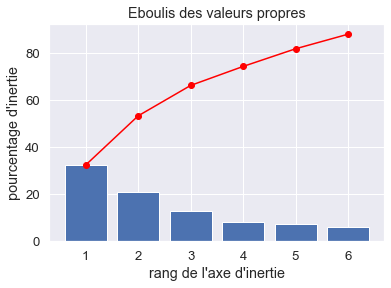

In [26]:
# Eboulis des valeurs propres
sns.set(font_scale=1.2)
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

**Interprétation:** <br/>
    À partir du rang 4, le pourcentage d'inertie change peu. Les quatres premiers axes sur le cercle de corrélation et la projection des individus seront les plus important.

In [27]:
# choix du nombre de composantes après éboulis des valeurs propres
n_comp = 4

In [28]:
# Recentrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [29]:
# Recalcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

* Création d'un dataframe à partir des valeurs de la PCA.

In [30]:
df = pd.DataFrame(pca.components_)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.053526,-5.551115e-17,0.056845,0.355038,0.345595,0.350942,0.345545,0.337129,0.306474,0.172109,0.338223,0.121146,0.341805,-0.102650,-0.0,0.097172,0.052633
1,-0.011326,2.081668e-17,0.046537,-0.343738,-0.355759,-0.329634,-0.349857,0.357148,0.213408,0.053644,0.351628,0.287080,0.349341,0.023179,0.0,0.131518,-0.004660
2,-0.549853,-0.000000e+00,-0.053575,-0.069960,-0.066243,-0.103259,-0.014981,-0.107713,0.063467,0.428782,-0.104035,-0.105501,-0.111640,-0.607221,-0.0,0.241667,0.116620
3,-0.222708,-5.551115e-17,0.679140,0.031923,0.024870,0.023990,0.043155,-0.020917,-0.287337,0.038726,-0.058110,0.548849,-0.078853,-0.068255,0.0,-0.252944,-0.145349


In [31]:
df = df.transpose()
df

,0,1,2,3
0,-5.352556e-02,-1.132623e-02,-0.549853,-2.227080e-01
1,-5.551115e-17,2.081668e-17,-0.000000,-5.551115e-17
2,5.684507e-02,4.653659e-02,-0.053575,6.791396e-01
3,3.550376e-01,-3.437377e-01,-0.069960,3.192335e-02
4,3.455948e-01,-3.557587e-01,-0.066243,2.486961e-02
5,3.509418e-01,-3.296340e-01,-0.103259,2.399029e-02
6,3.455449e-01,-3.498572e-01,-0.014981,4.315517e-02
7,3.371294e-01,3.571477e-01,-0.107713,-2.091682e-02
8,3.064737e-01,2.134076e-01,0.063467,-2.873366e-01
9,1.721087e-01,5.364438e-02,0.428782,3.872563e-02


In [32]:
df.columns += 1
df.index = pivot.columns
df

,1,2,3,4
Élément,,,,
Alimentation pour touristes,-5.352556e-02,-1.132623e-02,-0.549853,-2.227080e-01
Aliments pour animaux,-5.551115e-17,2.081668e-17,-0.000000,-5.551115e-17
Autres utilisations (non alimentaire),5.684507e-02,4.653659e-02,-0.053575,6.791396e-01
Disponibilité alimentaire (Kcal/personne/jour),3.550376e-01,-3.437377e-01,-0.069960,3.192335e-02
Disponibilité alimentaire en quantité (kg/personne/an),3.455948e-01,-3.557587e-01,-0.066243,2.486961e-02
Disponibilité de matière grasse en quantité (g/personne/jour),3.509418e-01,-3.296340e-01,-0.103259,2.399029e-02
Disponibilité de protéines en quantité (g/personne/jour),3.455449e-01,-3.498572e-01,-0.014981,4.315517e-02
Disponibilité intérieure,3.371294e-01,3.571477e-01,-0.107713,-2.091682e-02
Exportations - Quantité,3.064737e-01,2.134076e-01,0.063467,-2.873366e-01


<AxesSubplot:ylabel='Élément'>

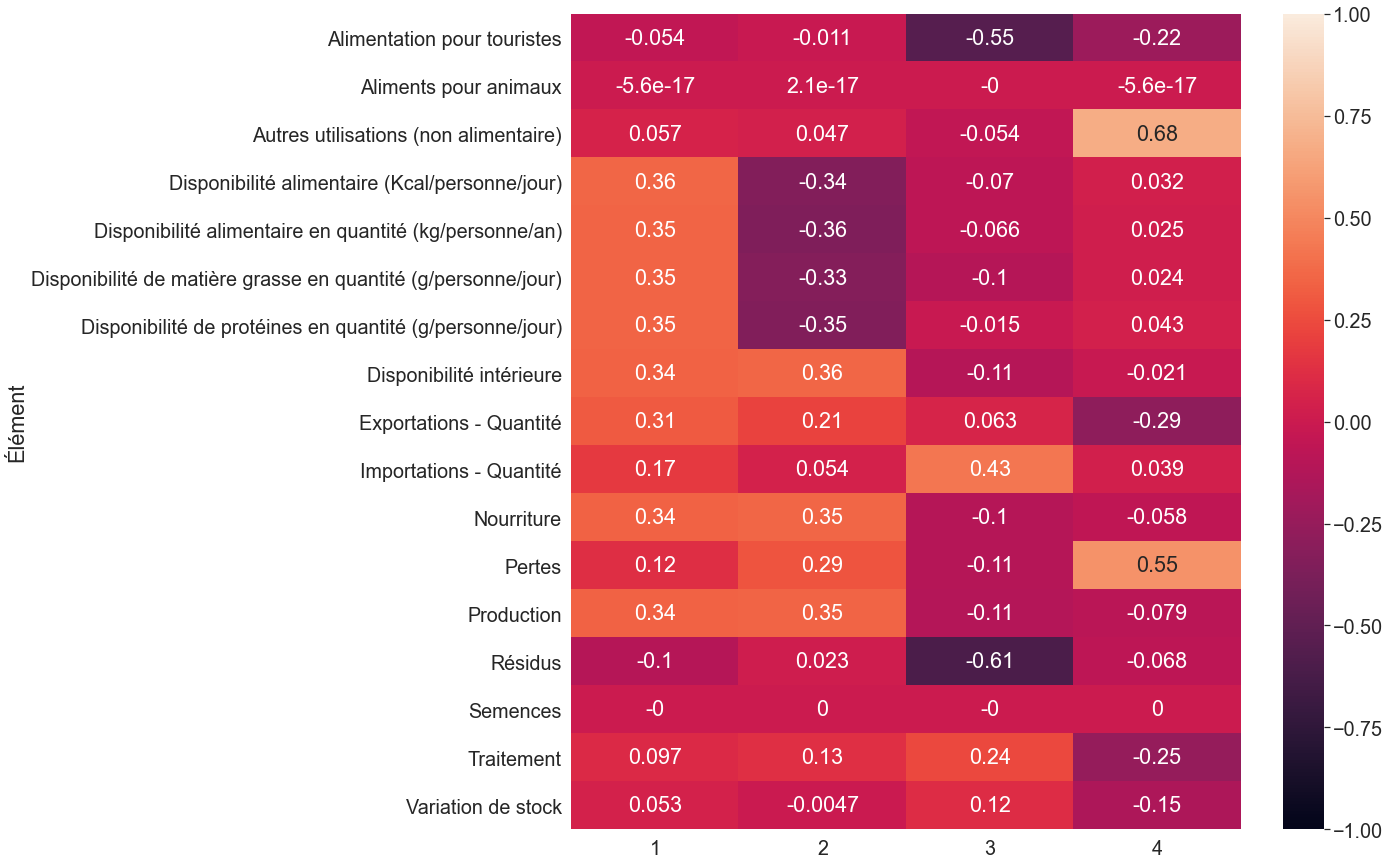

In [33]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df, annot=True,vmin=-1, vmax=1, ax=ax)

**Interprétation :**
- ***Axe 1***<br/>
Les différentes disponibilités alimentaires, la disponibilité intérieure, la nourriture et la production s'opposent aux résidus.
- ***Axe 2***<br/>
La disponibilité intérieure, la nourriture et la production s'opposent aux différentes disponibilités alimentaires.

- ***Axe 3***<br/>
L'importation s'oppose à l'alimentation pour touristes et les résidus.

- ***Axe 4***<br/>
Les autres utilisations (non alimentaire) et les pertes s'opposent à l'exportation et le traitement.

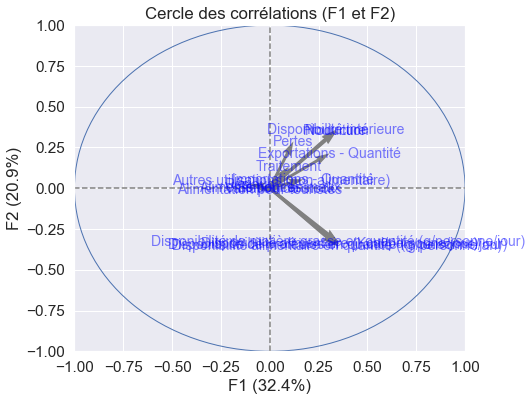

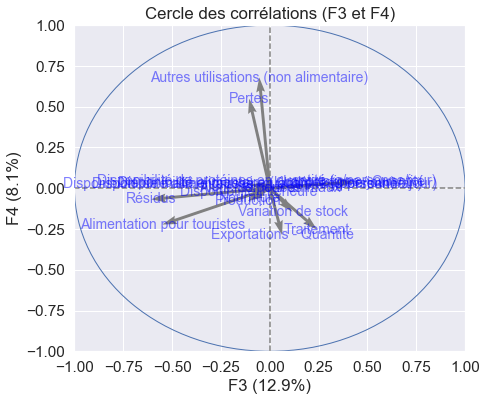

In [34]:
# Cercle des corrélations
pcs = pca.components_
sns.set(font_scale=1.4)
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

In [35]:
# Projection des individus
X_projected = pca.transform(X_scaled)

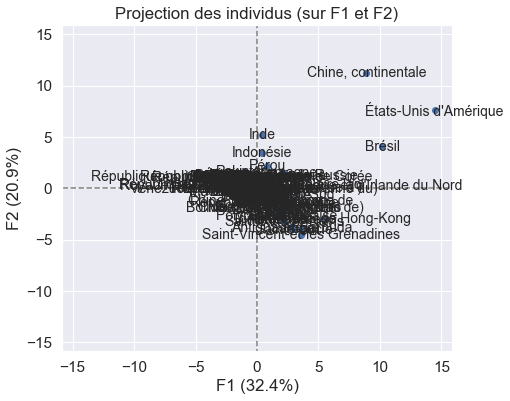

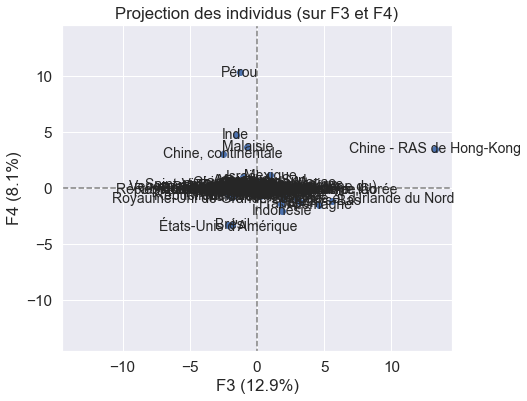

In [36]:
sns.set(font_scale=1.4)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], labels = np.array(names))

plt.show()

**Interprétation** :
- États Unis d'Amérique, Chine continentale et Brésil se démarquent sur le premier plan factoriel.
- Inde, Pérou, Chine - RAS de Hong Kong se démarquent sur le deuxième plan factoriel.

### Le Clustering ###

* La méthode des k-means

In [37]:
data_k = pd.DataFrame({"Pays": pivot.index.values,"Alimentation pour touristes" : pivot["Alimentation pour touristes"].values, "Aliments pour animaux" : pivot['Aliments pour animaux'].values,
              'Autres utilisations (non alimentaire)': pivot["Autres utilisations (non alimentaire)"].values,'Disponibilité alimentaire (Kcal/personne/jour)': pivot['Disponibilité alimentaire (Kcal/personne/jour)'].values,
              'Disponibilité alimentaire en quantité (kg/personne/an)': pivot['Disponibilité alimentaire en quantité (kg/personne/an)'].values, 'Disponibilité de matière grasse en quantité (g/personne/jour)': pivot['Disponibilité de matière grasse en quantité (g/personne/jour)'].values,
                 'Disponibilité de protéines en quantité (g/personne/jour)': pivot['Disponibilité de protéines en quantité (g/personne/jour)'].values,'Disponibilité intérieure': pivot['Disponibilité intérieure'].values,
                       'Exportations - Quantité': pivot['Exportations - Quantité'].values, 'Importations - Quantité': pivot['Importations - Quantité'].values, 'Nourriture':  pivot['Nourriture'].values,
                       'Pertes': pivot['Pertes'].values,'Production': pivot['Production'].values,'Résidus': pivot['Résidus'].values,'Semences': pivot['Semences'].values,
                       'Traitement': pivot['Traitement'].values,'Variation de stock': pivot['Variation de stock'].values})
data_k

,Pays,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
0,Afghanistan,NaN,NaN,NaN,5.0,1.53,0.33,0.54,57.0,NaN,29.0,55.0,2.0,28.0,0.0,NaN,NaN,0.0
1,Afrique du Sud,0.0,NaN,NaN,143.0,35.69,9.25,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,NaN,NaN,0.0
2,Albanie,NaN,NaN,NaN,85.0,16.36,6.45,6.26,47.0,0.0,38.0,47.0,NaN,13.0,0.0,NaN,NaN,4.0
3,Algérie,0.0,NaN,NaN,22.0,6.38,1.50,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,NaN,NaN,0.0
4,Allemagne,NaN,NaN,NaN,71.0,19.47,4.16,7.96,1739.0,646.0,842.0,1609.0,NaN,1514.0,-38.0,NaN,167.0,-29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,NaN,NaN,NaN,147.0,43.47,9.25,14.80,412.0,94.0,433.0,412.0,NaN,48.0,0.0,NaN,NaN,-26.0
168,Équateur,0.0,NaN,NaN,83.0,19.31,6.35,6.15,341.0,0.0,0.0,324.0,17.0,340.0,0.0,NaN,NaN,-1.0
169,États-Unis d'Amérique,NaN,NaN,89.0,219.0,55.68,14.83,19.93,18266.0,3692.0,123.0,18100.0,NaN,21914.0,0.0,NaN,77.0,80.0
170,Éthiopie,0.0,NaN,NaN,0.0,0.13,0.03,0.04,14.0,NaN,1.0,14.0,1.0,14.0,0.0,NaN,NaN,0.0


In [38]:
# préparation des données pour le clustering
data_kmeans = data_k[['Alimentation pour touristes', 'Aliments pour animaux','Autres utilisations (non alimentaire)','Disponibilité alimentaire (Kcal/personne/jour)',
                 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Disponibilité de matière grasse en quantité (g/personne/jour)',
                 'Disponibilité de protéines en quantité (g/personne/jour)','Disponibilité intérieure','Exportations - Quantité', 'Importations - Quantité', 'Nourriture','Pertes',
                 'Production','Résidus','Semences','Traitement','Variation de stock']]
data_kmeans = data_kmeans.fillna(0)
Xk = data_kmeans.values

In [39]:
# elbow methode (clustering)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_kmeans)
    distortions.append(kmeanModel.inertia_)

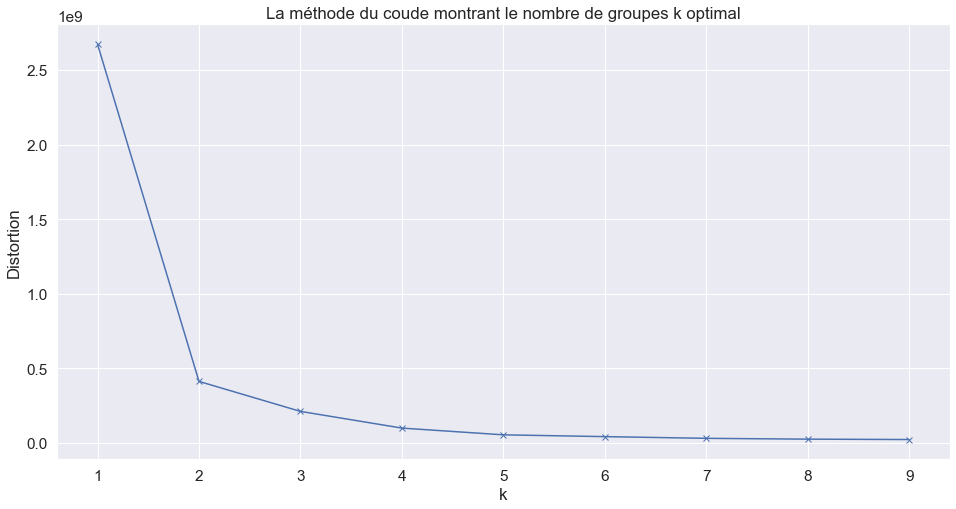

In [40]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('La méthode du coude montrant le nombre de groupes k optimal')
plt.show()

In [41]:
# Nombre de clusters souhaités avec la méthode du coude
n_clust = 4

In [42]:
# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
Xk_scaled = preprocessing.StandardScaler().fit_transform(Xk)

In [43]:
# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(Xk_scaled)

KMeans(n_clusters=4)

In [44]:
# Récupération des clusters attribués à chaque individu
clusters = km.labels_

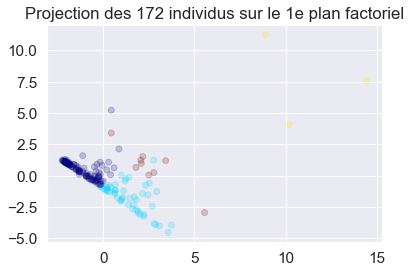

In [45]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=4).fit(Xk_scaled)
Xk_projected = pca.transform(Xk_scaled)
sns.set(font_scale=1.4)
plt.scatter(Xk_projected[:, 0], Xk_projected[:, 1], c=clusters.astype(int), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(Xk_projected.shape[0]))
plt.show(block=False)

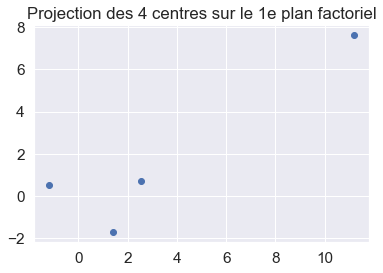

In [46]:
# Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
sns.set(font_scale=1.4)
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

In [47]:
data_centroid = pd.DataFrame(centroids).transpose()
data_centroid.columns += 1
data_centroid.index = data_kmeans.columns
data_centroid

,1,2,3,4
Alimentation pour touristes,-0.015812,0.267594,-0.061426,-1.304389
Aliments pour animaux,0.000000,0.000000,0.000000,0.000000
Autres utilisations (non alimentaire),-0.007726,0.011566,0.323161,-0.079694
Disponibilité alimentaire (Kcal/personne/jour),-0.606229,1.142329,1.425757,0.393662
Disponibilité alimentaire en quantité (kg/personne/an),-0.602682,1.151524,1.167729,0.384604
Disponibilité de matière grasse en quantité (g/personne/jour),-0.592917,1.124400,1.606769,0.273691
Disponibilité de protéines en quantité (g/personne/jour),-0.599211,1.117146,1.086192,0.564559
Disponibilité intérieure,-0.200427,-0.064841,6.817964,0.522171
Exportations - Quantité,-0.170110,-0.146319,5.969759,0.899444
Importations - Quantité,-0.225156,-0.074915,0.562264,2.963987


--------------------
Catégorie Alimentation pour touristes 



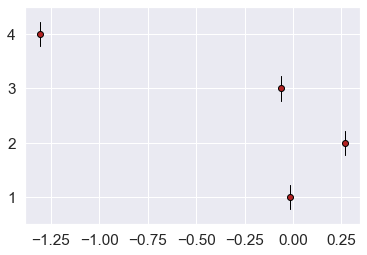

--------------------
Catégorie Aliments pour animaux 



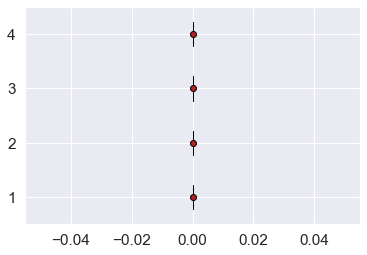

--------------------
Catégorie Autres utilisations (non alimentaire) 



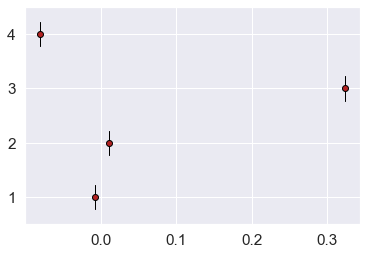

--------------------
Catégorie Disponibilité alimentaire (Kcal/personne/jour) 



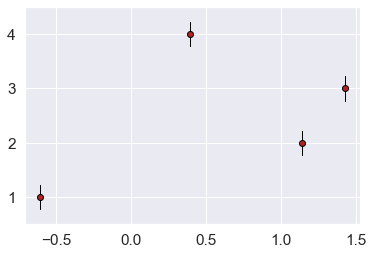

--------------------
Catégorie Disponibilité alimentaire en quantité (kg/personne/an) 



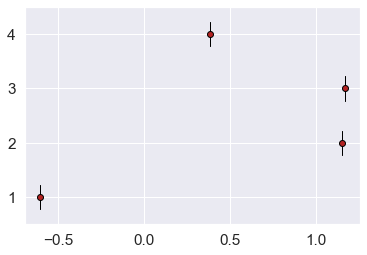

--------------------
Catégorie Disponibilité de matière grasse en quantité (g/personne/jour) 



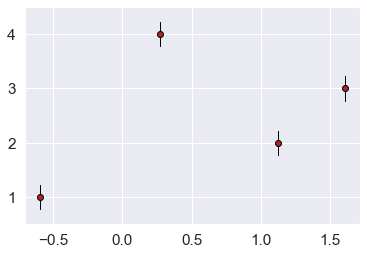

--------------------
Catégorie Disponibilité de protéines en quantité (g/personne/jour) 



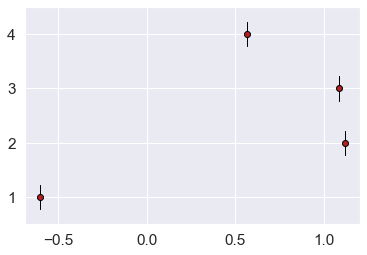

--------------------
Catégorie Disponibilité intérieure 



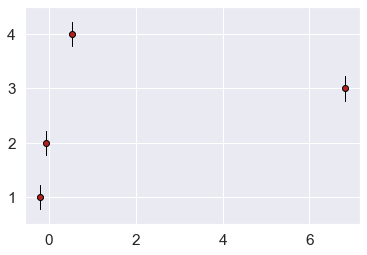

--------------------
Catégorie Exportations - Quantité 



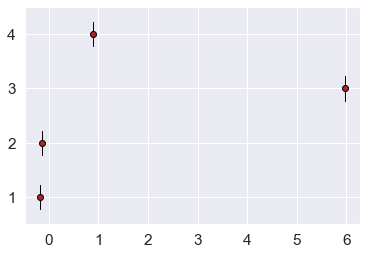

--------------------
Catégorie Importations - Quantité 



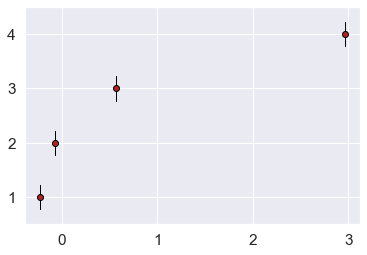

--------------------
Catégorie Nourriture 



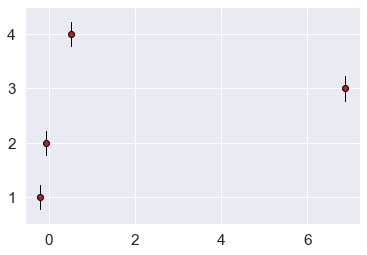

--------------------
Catégorie Pertes 



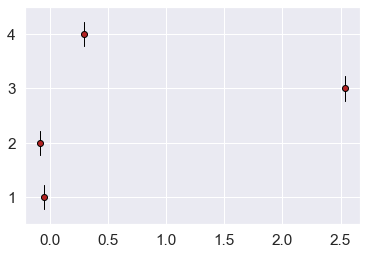

--------------------
Catégorie Production 



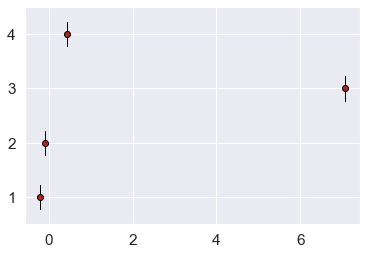

--------------------
Catégorie Résidus 



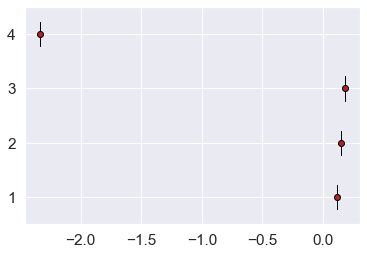

--------------------
Catégorie Semences 



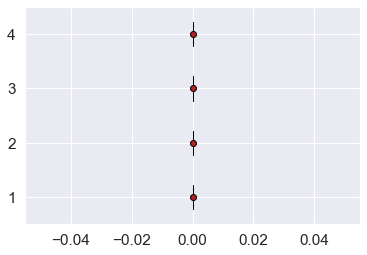

--------------------
Catégorie Traitement 



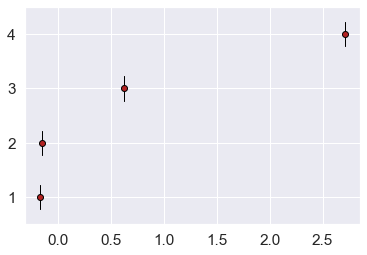

--------------------
Catégorie Variation de stock 



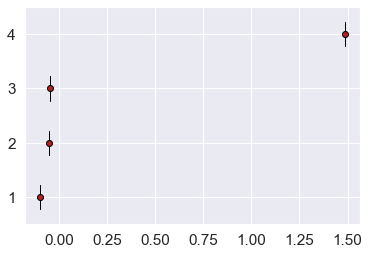

In [48]:
for cat in data_centroid.index:
    subset = data_centroid.loc[data_centroid.index == cat, :] 
    print("-"*20)
    print(color.UNDERLINE + 'Catégorie' ,cat,'\n' + color.END)
    
    # Propriétés graphiques (pas très importantes)    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
    plt.boxplot(subset, labels=data_centroid.columns, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

**Interprétation :**
- ***L'alimentation pour touristes, les résidus***<br/>
La variable est la plus faible dans le cluster 4 contrairement aux autres.

- ***Les autres utilisations (non alimentaire), les différents disponibilités, l'importation***<br/>
Les variables sont les plus faibles dans le cluster 1 contrairement au cluster 4 où elles sont les plus fortes.

- ***La disponibilité intérieure, l'exportation, la nourriture, les pertes, la production***<br/>
Les variables sont les plus fortes dans le cluster 3 contrairement aux autres.

- ***Le Traitement***<br/>
Le traitement est le plus faible dans le cluster 4 contrairement au cluster 3 où il est le plus fort.

- ***La variation de stock***<br/>
La variation de stock est la plus faible dans le cluster 4 contrairement au cluster 2 où elle est la plus forte.

**Conclusion :**<br/>
   - les pays du cluster 1 ont en moyenne des disponibilités alimentaires , les autres utilisations non alimentaires et l'importation, faibles.
   
   - les pays du cluster 2 ont en moyenne leur variation de stock très haut.
   - les pays du cluster 3 ont la disponibilité intérieure, l'exportation, la nourriture, les pertes, la production et le traitement, faibles en général.
   - les pays du cluster 4 ont l'alimentation pour touristes, les résidus, le traitement et la variation de stock faibles contrairement aux différentes disponibilités alimentaires, l'importation et les autres utilisations non alimentaires qui sont très haut.

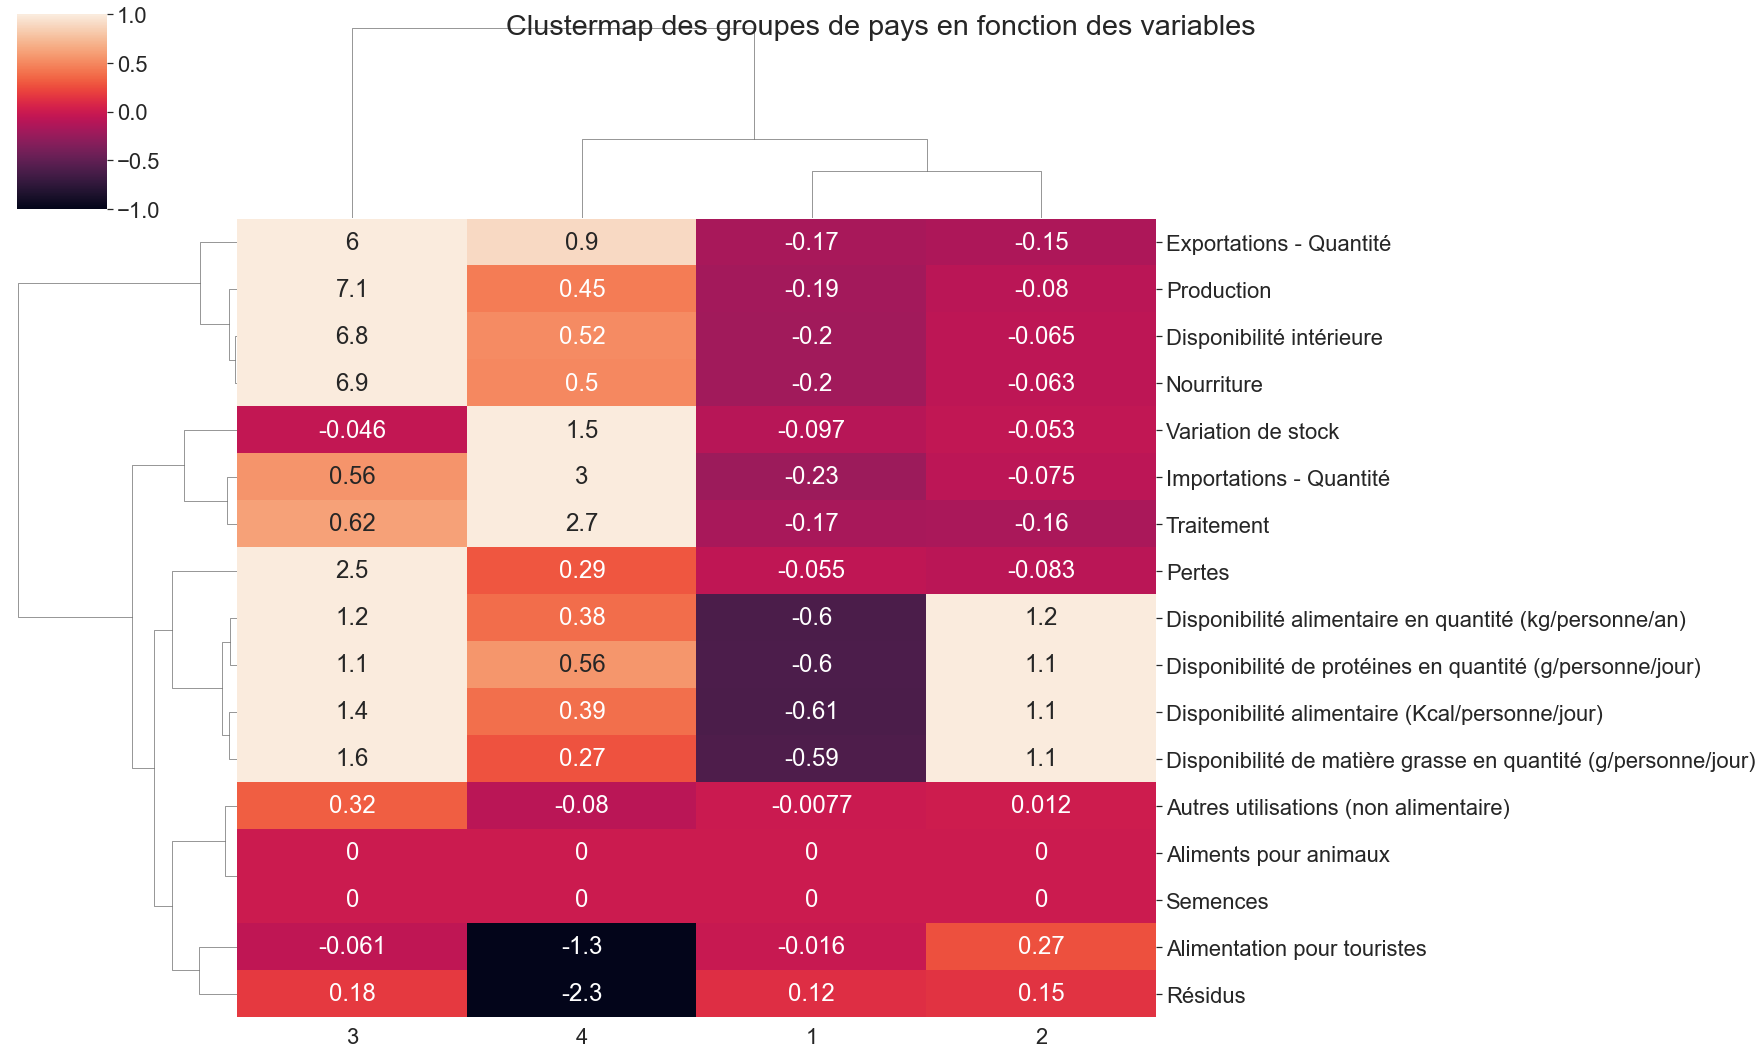

In [49]:
sns.set(font_scale=2)
sns.clustermap(data_centroid, annot=True,figsize=(25, 15),vmin=-1, vmax=1).fig.suptitle('Clustermap des groupes de pays en fonction des variables')
# Export to png
plt.savefig('heatmap.png')

* La classification ascendante hiérarchique

In [50]:
data_c = data_k
data_c

,Pays,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
0,Afghanistan,NaN,NaN,NaN,5.0,1.53,0.33,0.54,57.0,NaN,29.0,55.0,2.0,28.0,0.0,NaN,NaN,0.0
1,Afrique du Sud,0.0,NaN,NaN,143.0,35.69,9.25,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,NaN,NaN,0.0
2,Albanie,NaN,NaN,NaN,85.0,16.36,6.45,6.26,47.0,0.0,38.0,47.0,NaN,13.0,0.0,NaN,NaN,4.0
3,Algérie,0.0,NaN,NaN,22.0,6.38,1.50,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,NaN,NaN,0.0
4,Allemagne,NaN,NaN,NaN,71.0,19.47,4.16,7.96,1739.0,646.0,842.0,1609.0,NaN,1514.0,-38.0,NaN,167.0,-29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,NaN,NaN,NaN,147.0,43.47,9.25,14.80,412.0,94.0,433.0,412.0,NaN,48.0,0.0,NaN,NaN,-26.0
168,Équateur,0.0,NaN,NaN,83.0,19.31,6.35,6.15,341.0,0.0,0.0,324.0,17.0,340.0,0.0,NaN,NaN,-1.0
169,États-Unis d'Amérique,NaN,NaN,89.0,219.0,55.68,14.83,19.93,18266.0,3692.0,123.0,18100.0,NaN,21914.0,0.0,NaN,77.0,80.0
170,Éthiopie,0.0,NaN,NaN,0.0,0.13,0.03,0.04,14.0,NaN,1.0,14.0,1.0,14.0,0.0,NaN,NaN,0.0


In [51]:
# Theme du ou des parcours auxquels appartient le cours (data, developpement, marketing, etc.)
theme = data_k.columns

In [52]:
# préparation des données pour le clustering
data_cluester = data_k[['Alimentation pour touristes', 'Aliments pour animaux','Autres utilisations (non alimentaire)','Disponibilité alimentaire (Kcal/personne/jour)',
                 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Disponibilité de matière grasse en quantité (g/personne/jour)',
                 'Disponibilité de protéines en quantité (g/personne/jour)','Disponibilité intérieure','Exportations - Quantité', 'Importations - Quantité', 'Nourriture','Pertes',
                 'Production','Résidus','Semences','Traitement','Variation de stock']]
data_cluester = data_cluester.fillna(0)
Xc = data_cluester.values

In [53]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(Xc)
Xc_scaled = std_scale.transform(Xc)

In [54]:
# Clustering hiérarchique
Z = linkage(Xc_scaled, 'ward')

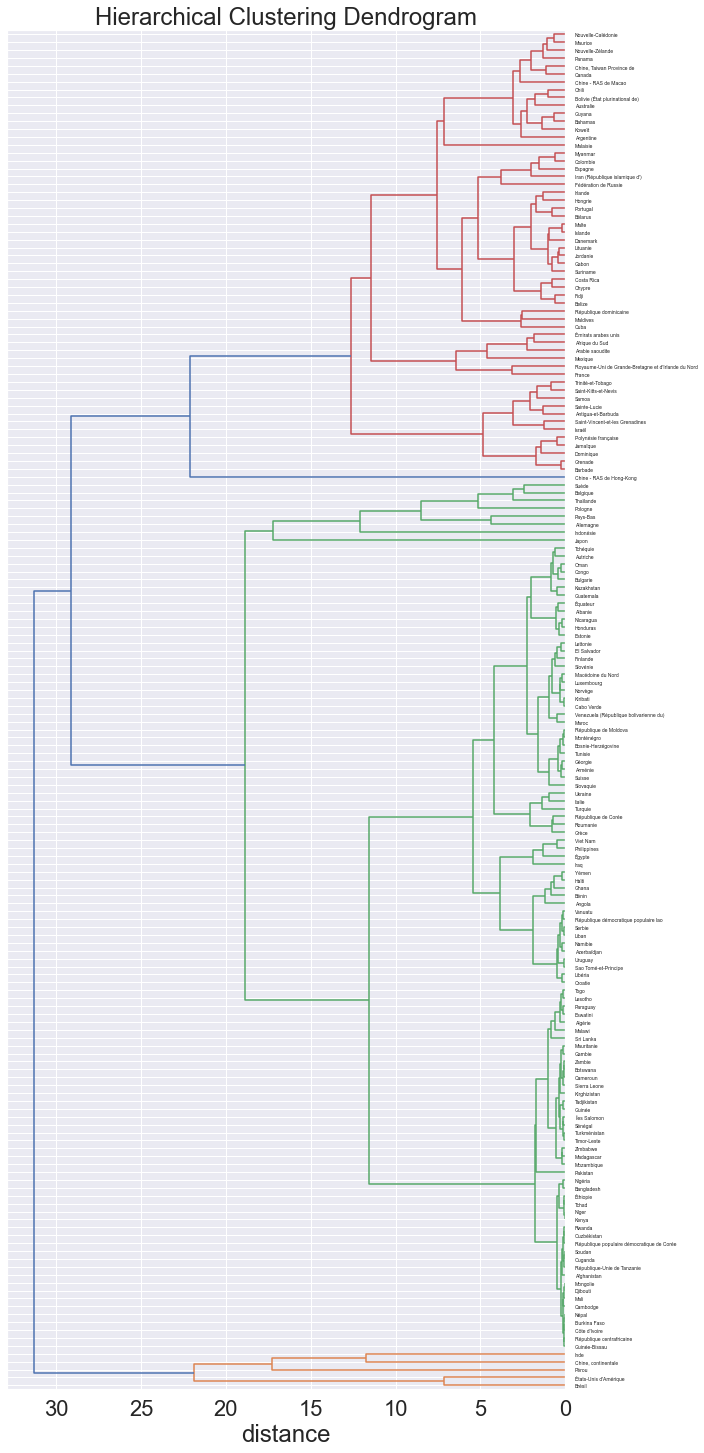

In [55]:
# Affichage du dendrogramme
plt.figure(figsize=(10,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(Z, labels = names, orientation = "left")
plt.show()

In [56]:
# Coupage du dendrogramme en 4 clusters
clusters = fcluster(Z, 4, criterion='maxclust')
Xp = "Pays"
data_map = data_c[[Xp]].pivot_table(index=Xp,columns=clusters,aggfunc=len,fill_value=0)
data_map

,1,2,3,4
Pays,,,,
Afghanistan,0,1,0,0
Afrique du Sud,0,0,1,0
Albanie,0,1,0,0
Algérie,0,1,0,0
Allemagne,0,1,0,0
...,...,...,...,...
Émirats arabes unis,0,0,1,0
Équateur,0,1,0,0
États-Unis d'Amérique,1,0,0,0


In [57]:
data_c[[Xp]].pivot_table(columns=clusters,aggfunc=len,fill_value=0)

,1,2,3,4
Pays,5,110,56,1


In [58]:
data_map.loc[data_map[1] == 1,:]

,1,2,3,4
Pays,,,,
Brésil,1,0,0,0
"Chine, continentale",1,0,0,0
Inde,1,0,0,0
Pérou,1,0,0,0
États-Unis d'Amérique,1,0,0,0


Text(0.5, 0.98, 'Clustermap des clusters en fonction des individus (pays)')

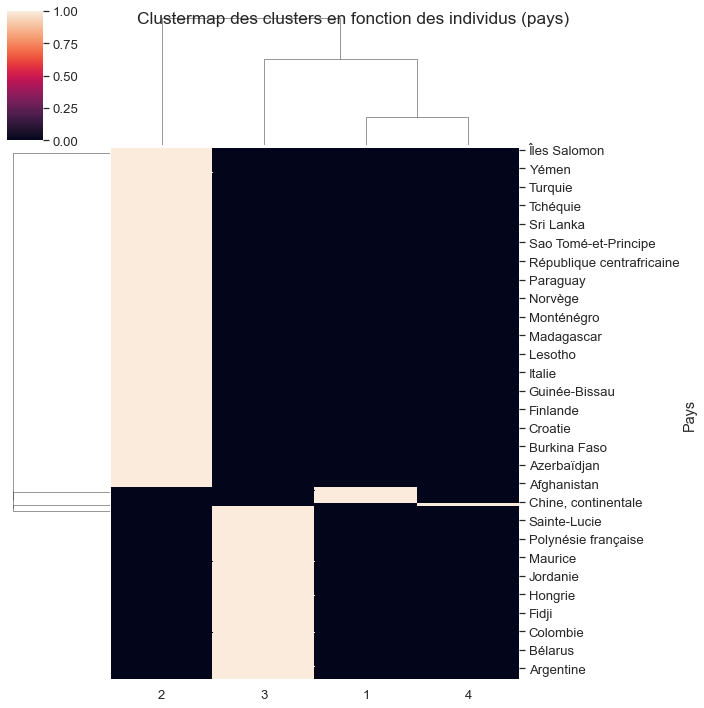

In [59]:
sns.set(font_scale=1.2)
sns.clustermap(data_map).fig.suptitle('Clustermap des clusters en fonction des individus (pays)')

**Conclusion :** <br/>
    Parmi les différents clusters, le cluster 1 contient un groupe de pays dont les disponibilités alimentaires en moyenne sont faibles contrairement aux autres clusters qui ont des disponibilités alimentaires en hausse. <br/>
    Les pays du cluster 1 sont donc à privilégier pour l'exportation des poulets.
   <br/> 
Les Pays concernés sont :
- Brésil
- Inde
- Pérou
- Chine continentale
- USA